# <center> Семинар 13 - Трекинг

**Домашнее задание**

***

In [14]:
# !pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116
# !pip install ultralytics filterpy lap
# !pip uninstall -y numpy protobuf
# !pip install -U numpy==1.23.5 protobuf==3.20.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.0/757.0 kB 13.9 MB/s eta 0:00:00
  Using cached filterpy-1.4.5.zip (177 kB)
  Preparing metadata (setup.py) ... done
  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=4cddfaed861e3d706589bfe0e4fe73ad542d2c7956f9a11b93669eafa5c7b1b1
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1628946 sha256=c1b12886b8aeb7b7434234a1abde136e852176ae0030831059488c35799f0227
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built filterpy lap
Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Successfully uninstalled numpy-1.25.2
Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Succes

In [2]:
from typing import Tuple
from time import time
import types
from pathlib import Path

from scipy.optimize import linear_sum_assignment
import numpy as np
import cv2
import matplotlib.pyplot as plt

from ultralytics import YOLO

# Вспомогательные функции

In [ ]:
def show_image(img: np.ndarray) -> None:
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()


def detection_visualization(
    img_path: Path, preds: np.ndarray
) -> np.ndarray:
    img = cv2.imread(str(img_path)) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(preds)):
        cv2.rectangle(
            img,
            (int(preds[i][0]), int(preds[i][1])),
            (int(preds[i][2]), int(preds[i][3])),
            color=(0, 255, 0),
            thickness=3,
        )
    return img


def tracking_visualization(
    img_path: Path, preds: np.ndarray
) -> np.ndarray:
    img = cv2.imread(str(img_path)) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(preds)):
        cv2.rectangle(
            img,
            (int(preds[i][0]), int(preds[i][1])),
            (int(preds[i][2]), int(preds[i][3])),
            color=(0, 255, 0),
            thickness=3,
        )
        cv2.putText(
            img,
            str(int(preds[i][4])),
            (int(preds[i][0]), int(preds[i][1])),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=2,
            color=(0, 255, 0),
            thickness=3
        )
    return img


# Датасет

В рамках данного семинара мы будем использовать трек `MOT17-09` из датасета MOT Challenge https://motchallenge.net/

Ссылка на скачивание датасета https://motchallenge.net/data/MOT17Det/

In [ ]:
# dataset_dir = Path("D:/УНИВЕР МФТИ/2 СЕМЕСТР/CV/cv_course_2024/MOT17/MOT17/train\MOT17-09-DPM\img1")  # путь к директории с изображениями трека MOT17-09
dataset_dir = Path("img1")  # путь к директории с изображениями трека MOT17-09

frames_list = sorted([f for f in dataset_dir.iterdir()])

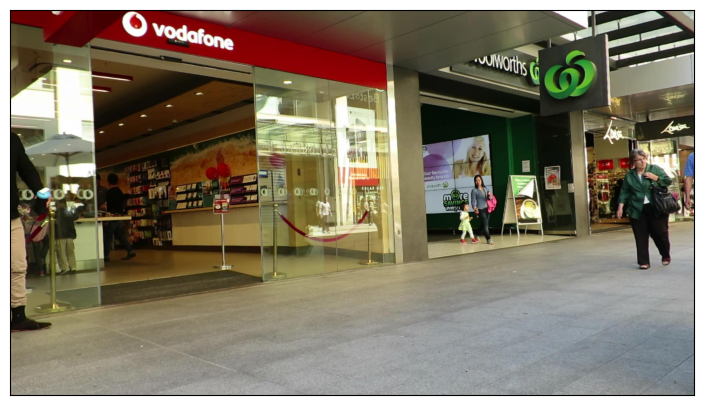

In [ ]:
img = cv2.cvtColor(cv2.imread(str(frames_list[0])), cv2.COLOR_BGR2RGB)
show_image(img)

# Детекция с помощью YOLOv8

В качестве бэкбона детекции мы будем использовать YOLOv8s из библиотеки ultralytics: https://github.com/ultralytics/ultralytics

In [ ]:
class YoloDetector:
    def __init__(self, conf_threshold: float = 0.5) -> None:
        self.backbone = YOLO("yolov8s.pt")
        self.conf_threshold = conf_threshold

    def __call__(self, img_path: Path) -> np.ndarray:
        preds = self.backbone.predict(source=img_path, conf=self.conf_threshold, show=False, classes=0)
        preds = preds[0].boxes.data.cpu().numpy()[:, :5]
        return preds

100%|██████████| 21.5M/21.5M [00:14<00:00, 1.54MB/s]



image 1/1 D:\ \2 \CV\cv_course_2024\MOT17\MOT17\train\MOT17-09-DPM\img1\000001.jpg: 384x640 7 persons, 316.0ms
Speed: 8.4ms preprocess, 316.0ms inference, 2963.4ms postprocess per image at shape (1, 3, 384, 640)


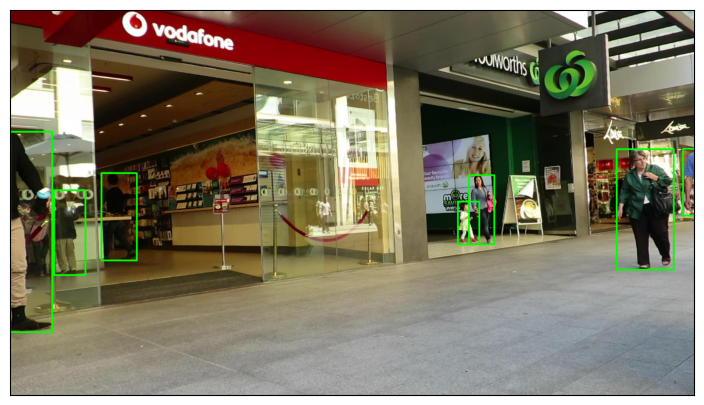

In [ ]:
detector = YoloDetector()
preds = detector(frames_list[0])

out_frame = detection_visualization(frames_list[0], preds)
show_image(out_frame)

# Алгоритм трекинга SORT

SORT: https://arxiv.org/abs/1602.00763

Разделы "3.3. Data Association" и "3.4. Creation and Deletion of Track Identities" описывают алгоритм соотнесения результатов детекции последовательных кадров:

> **3.3. Data Association**
>
> In assigning detections to existing targets, each target’s
> bounding box geometry is estimated by predicting its new
> location in the current frame. The assignment cost matrix is
> then computed as the intersection-over-union (IOU) distance
> between each detection and all predicted bounding boxes
> from the existing targets. The assignment is solved optimally
> using the Hungarian algorithm. Additionally, a minimum
> IOU is imposed to reject assignments where the detection to
> target overlap is less than $IOU_{min}$.
>
> We found that the IOU distance of the bounding boxes
> implicitly handles short term occlusion caused by passing targets.
> Specifically, when a target is covered by an occluding
> object, only the occluder is detected, since the IOU distance
> appropriately favours detections with similar scale. This allows
> both the occluder target to be corrected with the detection while
> the covered target is unaffected as no assignment is made.

> **3.4. Creation and Deletion of Track Identities**
>
> When objects enter and leave the image, unique identities
> need to be created or destroyed accordingly. For creating
> trackers, we consider any detection with an overlap less than
> $IOU_{min}$ to signify the existence of an untracked object. The
> tracker is initialised using the geometry of the bounding box
> with the velocity set to zero. Since the velocity is unobserved
> at this point the covariance of the velocity component is initialised
> with large values, reflecting this uncertainty. Additionally, the new
> tracker then undergoes a probationary period where the target needs
> to be associated with detections to accumulate enough evidence in order
> to prevent tracking of false positives.
>
> Tracks are terminated if they are not detected for $T_{Lost}$
> frames. This prevents an unbounded growth in the number
> of trackers and localisation errors caused by predictions over
> long durations without corrections from the detector. In all
> experiments $T_{Lost}$ is set to 1 for two reasons. Firstly, the constant
> velocity model is a poor predictor of the true dynamics
> and secondly we are primarily concerned with frame-to-frame
> tracking where object re-identification is beyond the scope of
> this work. Additionally, early deletion of lost targets aids efficiency.
> Should an object reappear, tracking will implicitly resume under a new identity.

# Венгерский алгоритм (Hungarian algorithm)

- [Wikipedia](https://en.wikipedia.org/wiki/Hungarian_algorithm)
- Реализация в библиотеке scipy: [`scipy.optimize.linear_sum_assignment`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html)
- Реализация в библиотеке [lap](https://github.com/gatagat/lap): `lap.lapjv`

## Задание 1:

Реализуйте Венгерский алгоритм. Сравните возвращаемые значения с библиотечной функцией [`scipy.optimize.linear_sum_assignment`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html).

In [2]:
def hungarian_algorithm(cost_matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Solves the assignment problem using the Hungarian algorithm.

    Args:
        cost_matrix (np.ndarray): Numpy array of shape (n, m) representing the cost matrix.

    Returns:
        A tuple of two numpy arrays (row_ind, col_ind) representing the row and column indices
        of the assigned cells in the cost matrix.
    """
    n, m = cost_matrix.shape
    u = np.zeros(n)
    v = np.zeros(m)
    ind = -np.ones(m, dtype=int)

    for i in range(n):
        links = -np.ones(m, dtype=int)
        mins = np.full(m, np.inf)
        visited = np.zeros(m, dtype=bool)
        marked_i = i
        marked_j = -1
        j = 0
        while True:
            j = -1
            for j1 in range(m):
                if not visited[j1]:
                    cur = cost_matrix[marked_i, j1] - u[marked_i] - v[j1]
                    if cur < mins[j1]:
                        mins[j1] = cur
                        links[j1] = marked_j
                    if j == -1 or mins[j1] < mins[j]:
                        j = j1
            delta = mins[j]
            for j1 in range(m):
                if visited[j1]:
                    u[ind[j1]] += delta
                    v[j1] -= delta
                else:
                    mins[j1] -= delta
            u[i] += delta
            visited[j] = True
            marked_j = j
            marked_i = ind[j]
            if marked_i == -1:
                break
        while True:
            if links[j] != -1:
                ind[j] = ind[links[j]]
                j = links[j]
            else:
                break
        ind[j] = i

    result = np.array([[ind[j], j] for j in range(m) if ind[j] != -1])
    row_ind = result[:, 0]
    col_ind = result[:, 1]
    return row_ind, col_ind

In [3]:
cost_matrix = np.array([[1, 2, 3],
                        [4, 5, 6],
                        [7, 8, 9]])
my_row_ind, my_col_ind = hungarian_algorithm(cost_matrix)
my_cost = cost_matrix[my_row_ind, my_col_ind].sum()
row_ind, col_ind = linear_sum_assignment(cost_matrix)
cost = cost_matrix[row_ind, col_ind].sum()

assert my_cost == cost

# Алгоритм трекинга ByteTrack

- Статья https://arxiv.org/abs/2110.06864
- Код https://github.com/ifzhang/ByteTrack


## Вопрос 1:

В чем заключается ключевая особенность метода BYTE?

**Ответ:**
Ключевая особенность метода ByteTrack заключается в его способности ассоциировать практически каждую рамку обнаружения, включая те, которые имеют низкие значения уверенности. При этом другие методы отслеживания объектов обычно используют только высоко уверенные детекции. Подход ByteTrack позволяет минимизировать пропуски реальных объектов, которые могут иметь низкую уверенность из-за сложных условий съемки. Благодаря этому, ByteTrack обеспечивает более целостное и точное отслеживание объектов, уменьшая количество разрывов и пропусков в траекториях.

In [4]:
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack
!pip install -r requirements.txt
!python setup.py develop
%cd ..
!pip install cython
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install cython_bbox

Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007
Receiving objects: 100% (2007/2007), 79.60 MiB | 28.59 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
/content/ByteTrack
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 61.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.tom

In [9]:
!ls
%cd ByteTrack

ByteTrack  sample_data
/content/ByteTrack


In [13]:
!pip install yolox
!pip install loguru
!pip install thop

  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.wh

In [ ]:
from yolox.tracker.byte_tracker import BYTETracker

fps = 30
frame_size = (1080, 1920)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_file = 'output.mp4'
video_writer = cv2.VideoWriter(output_file, fourcc, fps, frame_size[::-1])

args = types.SimpleNamespace(**{
    "track_thresh": 0.5,
    "track_buffer": 30,
    "match_thresh": 0.8,
    "mot20": False,

})
tracker = BYTETracker(args, frame_rate=fps)

det_times = []
track_times = []

for frame_path in frames_list:
    s_time = time()
    detections = detector(frame_path)
    det_times.append((time() - s_time) * 1000)  # in ms
    s_time = time()
    tracks = tracker.update(detections, frame_size, frame_size)
    track_times.append((time() - s_time) * 1000)  # in ms
    tracks = [t.tlbr.tolist() + [t.track_id] for t in tracks]
    out_frame = tracking_visualization(frame_path, tracks)
    video_writer.write(cv2.cvtColor(out_frame, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(f"./output/{str(frame_path.name)}", cv2.cvtColor(out_frame, cv2.COLOR_RGB2BGR))
video_writer.release()

print(f"mean detection time: {np.mean(det_times)}, mean track time: {np.mean(track_times)}")

## Задание 2

Объедините BYTE и любой трекер с Re-ID признаками (например, FairMOT). Можно воспользоваться инструкциями из репозитория: https://github.com/ifzhang/ByteTrack/tree/main/tutorials

Ответом на это задание должен быть код, записывающий видео работы метода для трека MOT17-09 в файл `reid_out.mp4`. Убедитесь, что код работает "end-to-end".

In [5]:
!git clone https://github.com/ifzhang/FairMOT.git

Cloning into 'FairMOT'...
remote: Enumerating objects: 719, done.
remote: Total 719 (delta 0), reused 0 (delta 0), pack-reused 719
Receiving objects: 100% (719/719), 63.34 MiB | 22.74 MiB/s, done.
Resolving deltas: 100% (383/383), done.


In [7]:
!cp ByteTrack/yolox/tracker/byte_tracker.py FairMOT/src/lib/tracker/

In [18]:
%cd FairMOT

/content/FairMOT


In [25]:
!ls

assets	build  experiments  LICENSE  output.mp4  README.md  requirements.txt  src  videos


In [41]:
!pip install -r requirements.txt

In [30]:
import sys
sys.path.append('/content/FairMOT/src/lib')

In [56]:
%cd /content/FairMOT

/content/FairMOT


In [61]:
!ls

build		dcn_v2.py    LICENSE  __pycache__  setup.py  testcpu.py
DCNv2.egg-info	__init__.py  make.sh  README.md    src	     testcuda.py


In [58]:
%cd src/lib/models/networks

/content/FairMOT/src/lib/models/networks


In [59]:
# %cd FairMOT/src/lib/models/networks
!git clone https://github.com/CharlesShang/DCNv2.git
%cd DCNv2
!python setup.py develop

Cloning into 'DCNv2'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 214 (delta 64), reused 49 (delta 49), pack-reused 137
Receiving objects: 100% (214/214), 1.40 MiB | 28.75 MiB/s, done.
Resolving deltas: 100% (133/133), done.
/content/FairMOT/src/lib/models/networks/DCNv2
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        *******************************************************************

In [62]:
!python setup.py build_ext --inplace

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:500: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
building '_ext' extension
g++ -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/content/FairMOT/src/lib/models/networks/DCNv2/src -I/usr/local/lib/python3.10/dist-packages/torch/include -I/usr/local/lib/python3.10/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.10/dist-packages/torch/include/TH -I/usr/local/lib/python3.10/dist-packages/torch/include/THC -I/usr/include/python3.10 -c /content/FairMOT/src/lib/models/networks/DCNv2/src/cpu/dcn_v2_cpu.cpp -o build/temp.linux-x86_64-cpython-310/content/FairMOT/src/lib/m

In [ ]:
import cv2
import numpy as np
from yolox.tracker.byte_tracker import BYTETracker
# from FairMOT.tracker.multitracker import MultiTracker
from FairMOT.src.lib.tracker.multitracker import MultiTracker
# from FairMOT.src.lib.tracker.tracker import MultiTracker

# трекер BYTE
args = types.SimpleNamespace(**{
    "track_thresh": 0.5,
    "track_buffer": 30,
    "match_thresh": 0.8,
    "mot20": False,
})
tracker = BYTETracker(args, frame_rate=30)

#FairMOT
mt = MultiTracker()

#видео
cap = cv2.VideoCapture('MOT17-09-raw.webm')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    detections = detector(frame)

    # Обновление трекера BYTE
    tracks = tracker.update(detections, frame.shape[1], frame.shape[0])

    # Обновление трекера FairMOT
    mt.update(detections)

    # Визуализация
    out_frame = tracking_visualization(frame, tracks)
    cv2.imshow('Tracking', out_frame)

    # Запись видео
    video_writer.write(cv2.cvtColor(out_frame, cv2.COLOR_RGB2BGR))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_writer.release()
cv2.destroyAllWindows()